# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

Study on simple random sinusoidal images vs. real valued bent functions (maximaly non-linear) images

### Simple sinusoidal images:
Generate sinusoidal data with random phase and frequency:

$$Z = \sin(2\pi f_x x + \phi_x) \cos(2\pi f_y y + \phi_y)$$

Where:
- $f_x$ is the frequency multiplier for x
- $f_y$ is the frequency multiplier for y
- $\phi_x$ is the phase shift for x
- $\phi_y$ is the phase shift for y

### Real valued Bent functions:

$$Z = \cos(2\pi(aX + bY)) + \cos(2\pi(cX - dY))$$

Where $a$, $b$, $c$, and $d$ are parameters controlling the function's behavior.



## Imports and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo

In [3]:
import polcanet.reports as report
import polcanet.utils as ut
from polcanet import PolcaNet

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [4]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="SYNTH_dataset",
    description="POLCA-Net on Synthetic Sinudosial and Bent Images",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving Images: True, saving in path: /data1/deploy/polcanet/examples/notebooks/experiments/SYNTH_dataset


## Generate Synthetic Sinudosial and Bent Images

7.748604e-07 0.9999964
0.0 1.0


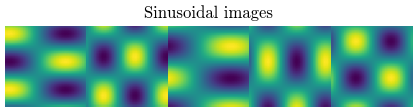

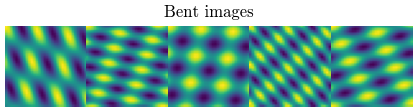

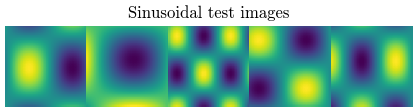

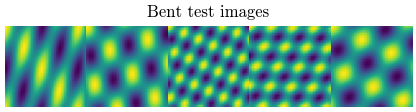

In [5]:
# Parameters
N = 32  # rows
M = 32  # cols
num_samples = 1000

# Generate 2D sinusoidal data
data_sin = ut.generate_2d_sinusoidal_data(N, M, num_samples=num_samples)
data_sin_test = ut.generate_2d_sinusoidal_data(N, M, num_samples=num_samples)

# Generate 2D real bent function images data
data_bent = ut.generate_bent_images(N, M, num_samples=3000)
data_bent_test = ut.generate_bent_images(N, M, num_samples=num_samples)
print(data_sin.min(), data_sin.max())
print(data_bent.min(), data_bent.max())
ut.set_fig_prefix("sin_train")
ut.plot_train_images(data_sin, "Sinusoidal images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_train")
ut.plot_train_images(data_bent, "Bent images", cmap="viridis", n=5)

ut.set_fig_prefix("sin_test")
ut.plot_train_images(data_sin_test, "Sinusoidal test images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_test")
ut.plot_train_images(data_bent_test, "Bent test images", cmap="viridis", n=5)

### Perform PCA on datasets

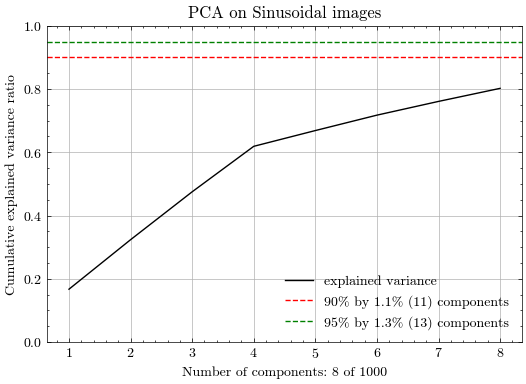

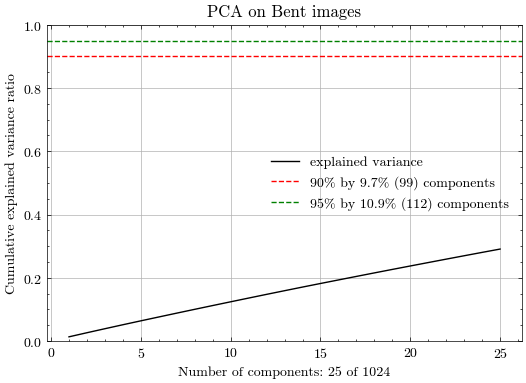

In [6]:
n_components = 8  # int((N*M)//100)
ut.set_fig_prefix("sin")
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, layout="constrained")
pca_sin = ut.get_pca(data_sin, ax=axs, title="PCA on Sinusoidal images", n_components=n_components)
plt.show()

n_components = int((N * M) / 40)
ut.set_fig_prefix("bent")
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, layout="constrained")
pca_bent = ut.get_pca(data_bent, ax=axs, title="PCA on Bent images", n_components=n_components)
plt.show()

## POLCA-Net

### Train on Sinusoidal Images

In [24]:
from polcanet.aencoders import ConvEncoder, LinearDecoder

ae_input = data_sin
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_sin.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder_sin = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_sin = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=5,
    act_fn=act_fn,
    bias=False,
)

model_sin = PolcaNet(
    encoder=encoder_sin,
    decoder=decoder_sin,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=0.01,  # variance sorting loss
    gamma=0.1,  # variance reduction loss
)
print(model_sin)
summary = torchinfo.summary(
    model_sin,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model_sin), "model_sin.txt")
ut.save_text(str(summary), "model_sin_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (9): SiLU()
        (10): Flatten(start_dim=1, end_dim=-1)
        (11): Linear(in_features=256, out_features=32, bias=True)
        (12): SiLU()
        (13): Linear(in_features=32, out_features=8, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=False)
      (1): Softsign()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Line

In [25]:
model_sin.to("cuda")
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0003423
Reconstruction Loss: 0.0001067
Orthogonality Loss: 0.001382
Center of Mass Loss: 0.005379
Variance Reduction Loss: 0.0004372


np.float64(0.0003423199086682871)

In [26]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0001091
Reconstruction Loss: 1.759e-05
Orthogonality Loss: 0.0005151
Center of Mass Loss: 0.00204
Variance Reduction Loss: 0.0001955


np.float64(0.00010905633098445833)

In [27]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0001102
Reconstruction Loss: 9.474e-06
Orthogonality Loss: 0.0006773
Center of Mass Loss: 0.001646
Variance Reduction Loss: 0.000165


np.float64(0.00011016281496267766)

In [ ]:
ut.set_fig_prefix("sin_train")
model_sin.loss_analyzer.print_report()
model_sin.loss_analyzer.plot_correlation_matrix(figsize=None)

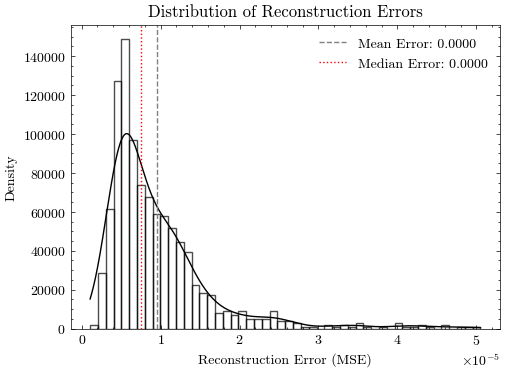

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0001


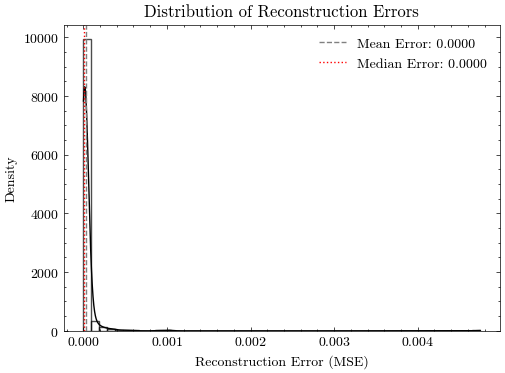

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0047


In [30]:
ut.set_fig_prefix("sin_train")
report.analyze_reconstruction_error(model_sin, data_sin, n_samples=1000)
ut.set_fig_prefix("sin_test")
report.analyze_reconstruction_error(model_sin, data_sin_test, n_samples=1000)

In [33]:
latents, reconstructed = model_sin.predict(data_sin)
data_sin.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 8))

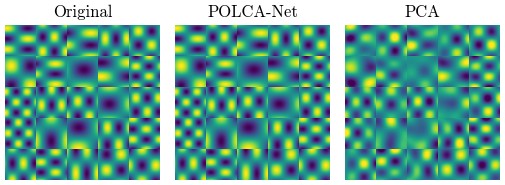

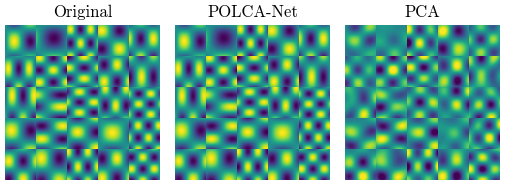

In [34]:
ut.set_fig_prefix("sin_train")
images = data_sin[0:25]
ut.plot_reconstruction_comparison(model_sin, pca_sin, images, cmap="viridis", nrow=5)
ut.set_fig_prefix("sin_test")
images = data_sin_test[0:25]
ut.plot_reconstruction_comparison(model_sin, pca_sin, images, cmap="viridis", nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0001
    - Max cosine similarity: 0.0012
    - Min cosine similarity: -0.0023
    


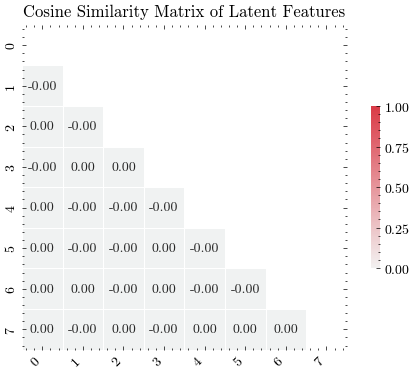

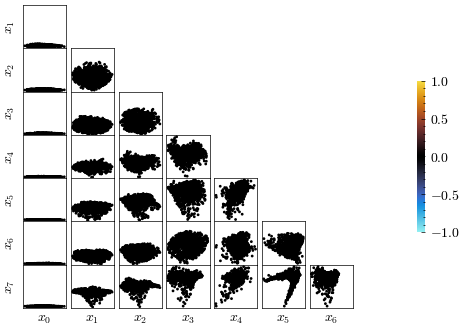


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0030
    - Max cosine similarity: 0.0858
    - Min cosine similarity: -0.0911
    


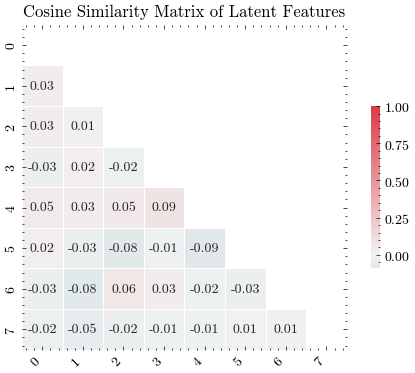

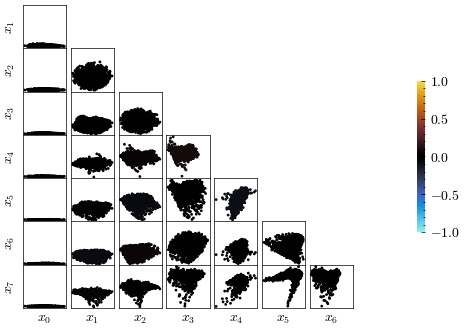

In [35]:
ut.set_fig_prefix("sin_train")
report.orthogonality_test_analysis(model_sin, data_sin)
ut.set_fig_prefix("sin_test")
report.orthogonality_test_analysis(model_sin, data_sin_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0790
    - Variance fit to exponential distribution (sum of squared differences):
     0.1653
    


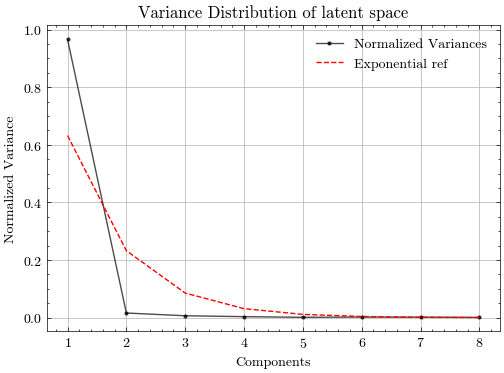

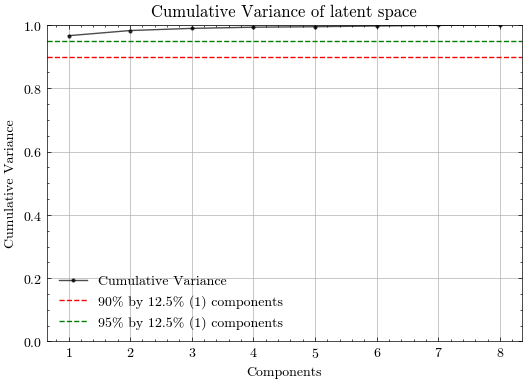

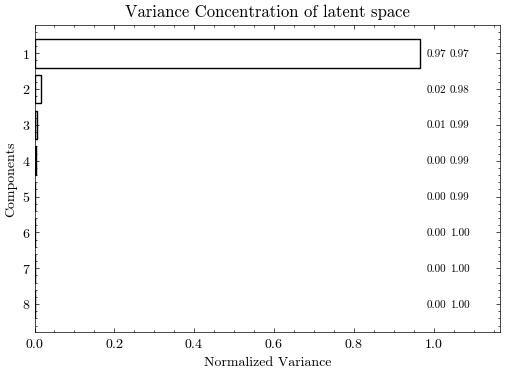


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0853
    - Variance fit to exponential distribution (sum of squared differences):
     0.1635
    


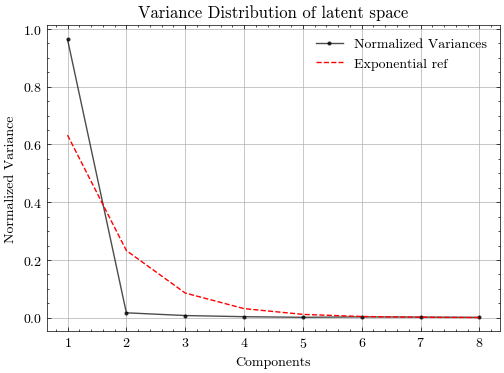

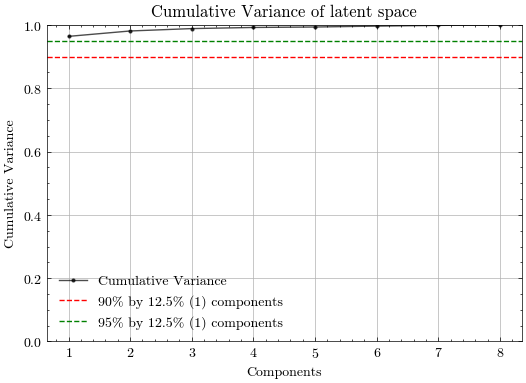

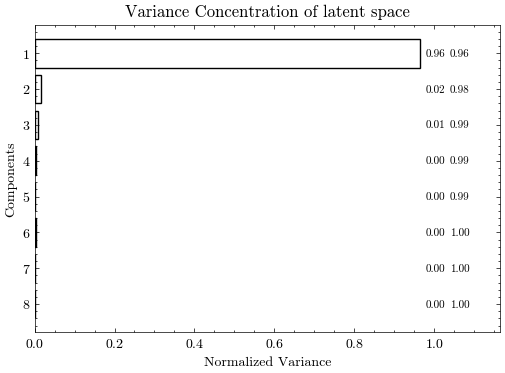

In [36]:
ut.set_fig_prefix("sin_train")
report.variance_test_analysis(model_sin, data_sin)
ut.set_fig_prefix("sin_test")
report.variance_test_analysis(model_sin, data_sin_test)

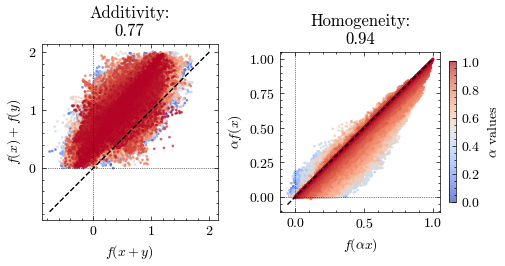

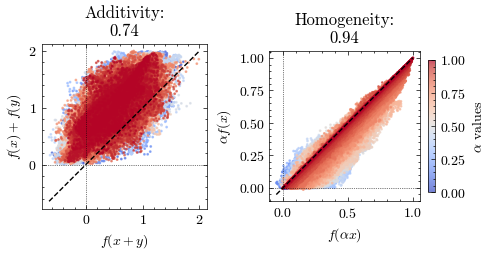

In [37]:
ut.set_fig_prefix("sin_train")
report.linearity_tests_analysis(model_sin, data_sin, alpha_min=0, num_samples=200)
ut.set_fig_prefix("sin_test")
report.linearity_tests_analysis(model_sin, data_sin_test, alpha_min=0, num_samples=200)

### Train on Bent Images

In [38]:
ae_input = data_bent
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_bent.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_bent = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_bent = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=5,
    act_fn=act_fn,
    bias=False,
)

model_bent = PolcaNet(
    encoder=encoder_bent,
    decoder=decoder_bent,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=0.01,  # variance sorting loss
    gamma=0.1,  # variance reduction loss
)
print(model_bent)
summary = torchinfo.summary(
    model_bent,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model_bent), "model_bent.txt")
ut.save_text(str(summary), "model_bent_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (9): SiLU()
        (10): Flatten(start_dim=1, end_dim=-1)
        (11): Linear(in_features=256, out_features=100, bias=True)
        (12): SiLU()
        (13): Linear(in_features=100, out_features=25, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=25, out_features=25, bias=False)
      (1): Softsign()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0):

In [39]:
model_bent.to("cuda")
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0003218
Reconstruction Loss: 0.000127
Orthogonality Loss: 0.001493
Center of Mass Loss: 0.002393
Variance Reduction Loss: 0.0002161


np.float64(0.0003218462225049734)

In [40]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0001551
Reconstruction Loss: 1.26e-05
Orthogonality Loss: 0.001209
Center of Mass Loss: 0.001093
Variance Reduction Loss: 0.0001066


np.float64(0.00015505176027848697)

In [41]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0001348
Reconstruction Loss: 5.943e-06
Orthogonality Loss: 0.0011
Center of Mass Loss: 0.0009384
Variance Reduction Loss: 9.465e-05


np.float64(0.00013483900086915432)

Loss Interaction Analysis Report:
Total interactions: 27000
Total conflicts: 5178
Overall conflict rate: 0.1918

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,com,var,4500,4470,0.993,-0.602,Strongly Conflicting
1,rec,var,4500,24,0.005,-0.003,Weakly Conflicting
2,rec,com,4500,33,0.007,-0.001,Weakly Conflicting
3,ort,var,4500,2,0.000,0.008,Weakly Cooperative
4,ort,com,4500,0,0.000,0.041,Weakly Cooperative
5,rec,ort,4500,649,0.144,0.124,Strongly Cooperative


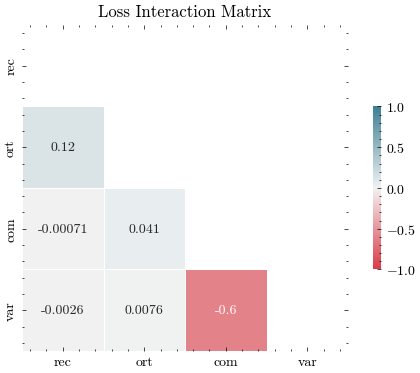

In [42]:
ut.set_fig_prefix("bent_train")
model_bent.loss_analyzer.print_report()
model_bent.loss_analyzer.plot_correlation_matrix(figsize=None)

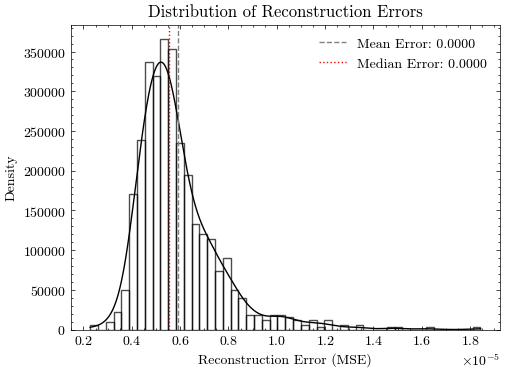

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0000


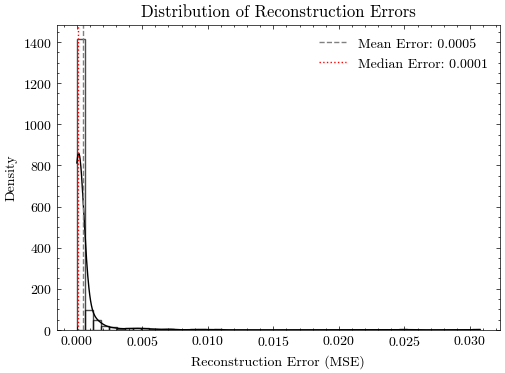

Mean Reconstruction Error: 0.0005
Median Reconstruction Error: 0.0001
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0308


In [43]:
ut.set_fig_prefix("bent_train")
report.analyze_reconstruction_error(model_bent, data_bent, n_samples=1000)
ut.set_fig_prefix("bent_test")
report.analyze_reconstruction_error(model_bent, data_bent_test, n_samples=1000)

In [44]:
latents, reconstructed = model_bent.predict(data_bent)
data_bent.shape, reconstructed.shape, latents.shape

((3000, 32, 32), (3000, 32, 32), (3000, 25))

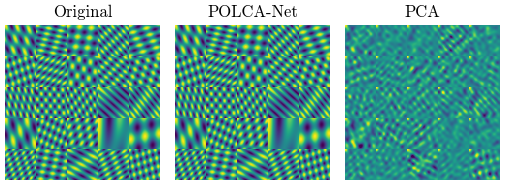

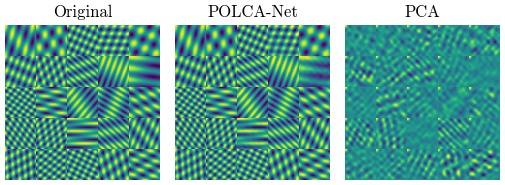

In [45]:
ut.set_fig_prefix("sin_train")
images = data_bent[0:25]
ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=5)
ut.set_fig_prefix("sin_test")
images = data_bent_test[0:25]
ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0004
    - Max cosine similarity: 0.0568
    - Min cosine similarity: -0.0728
    


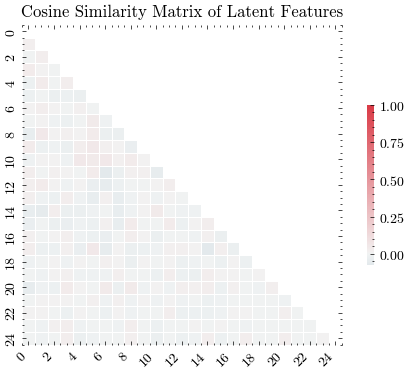

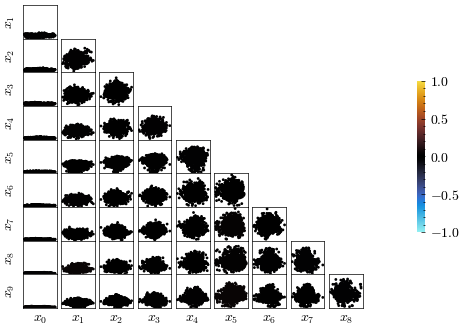


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0012
    - Max cosine similarity: 0.1286
    - Min cosine similarity: -0.0755
    


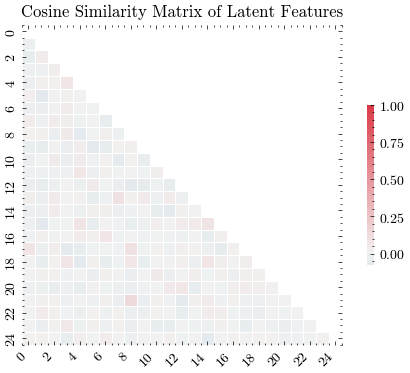

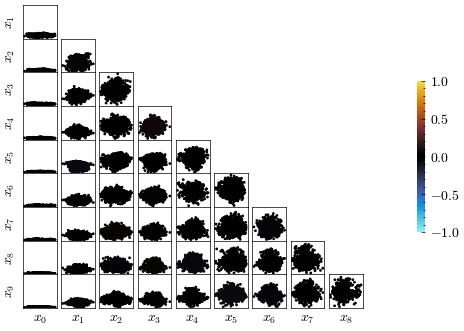

In [46]:
ut.set_fig_prefix("bent_train")
report.orthogonality_test_analysis(model_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.orthogonality_test_analysis(model_bent, data_bent_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.3556
    - Variance fit to exponential distribution (sum of squared differences):
     0.1394
    


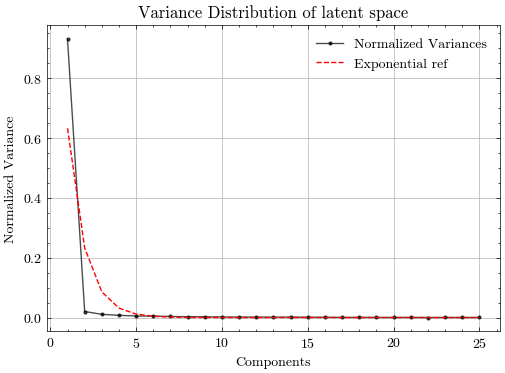

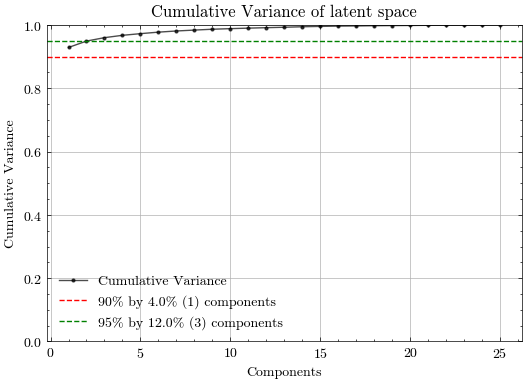

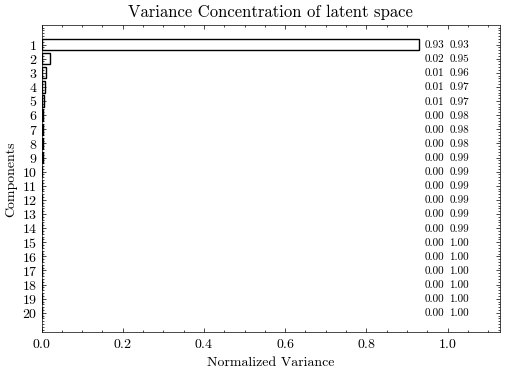


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.3537
    - Variance fit to exponential distribution (sum of squared differences):
     0.1410
    


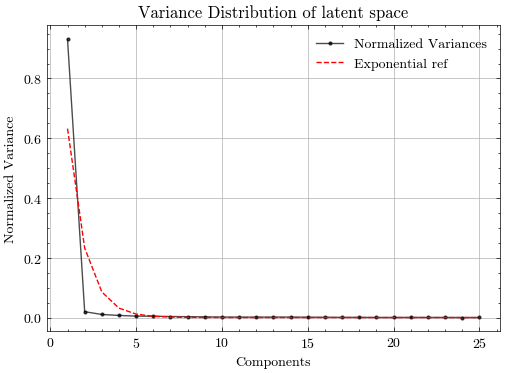

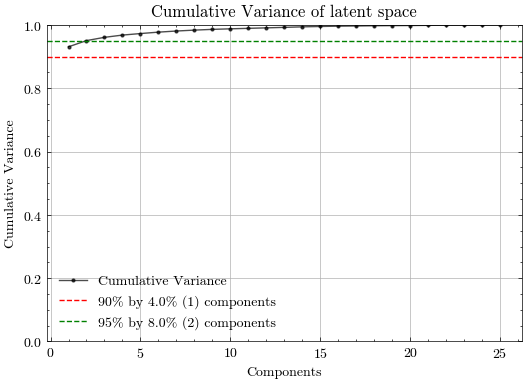

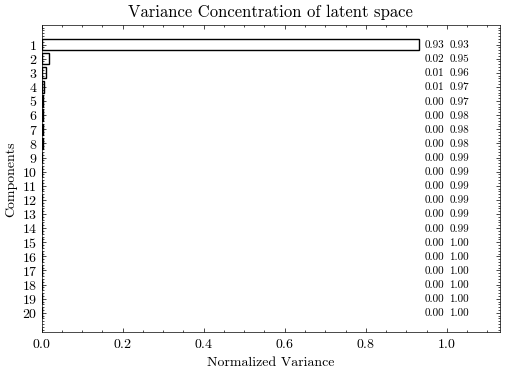

In [47]:
ut.set_fig_prefix("bent_train")
report.variance_test_analysis(model_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.variance_test_analysis(model_bent, data_bent_test)

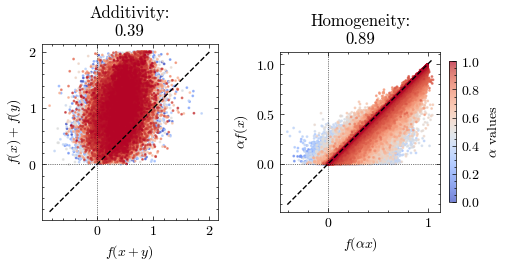

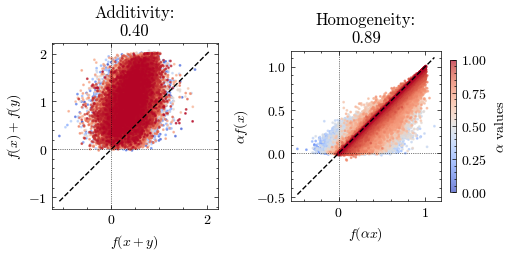

In [48]:
ut.set_fig_prefix("bent_train")
report.linearity_tests_analysis(model_bent, data_bent, alpha_min=0, num_samples=200)
ut.set_fig_prefix("bent_test")
report.linearity_tests_analysis(model_bent, data_bent_test, alpha_min=0, num_samples=200)

## Test Overall

In [49]:
experiment_data = {
    "Sinudoidal": (
        data_sin,
        model_sin,
        pca_sin,
    ),
    "Bent": (
        data_bent,
        model_bent,
        pca_bent,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,NMSE,PSNR,SSI
Method,,,
POLCA Sinudoidal,0.0000,50.9893,0.9999
PCA Sinudoidal,0.0397,20.8163,0.8427
POLCA Bent,0.0000,52.4442,1.0000
PCA Bent,0.1415,13.6371,0.4569
